<img src='https://kabardewata.com/uploads/image/news_agustus/bumbu-bali-restaurant.jpg' style='width:100%; position:absolute;'>
<h1 style='text-align:center; font-size:100px; position:relative; opacity:0.9; padding-top:200px;'>THE BATTLE OF NEIGHBORHOODS</h1>

# INTRODUCTION: BUSINESS PROBLEM

IN THIS PROJECT, WE TRY TO FINDING SOLUTION FOR A CHEFF WHO WANT TO OPEN RESTAURANT
HE DONT KNOW WHICH PLACE THAT HAVE MOST STRATEGIC LOCATION, SO THE CHEF CONTACT US AS DATA SCIENTIST TO SOLVE HIS BUSINESS PROBLEM AND GET INSIGHT ABOUT LOCATION TO OPEN HIS RESTAURANT


# DATA

the data that we will use are:
<ol>
<li>number of worker and company in every regency by <a href='https://bali.bps.go.id/statictable/2019/10/09/161/jumlah-perusahaan-dan-tenaga-kerja-industri-besar-dan-sedang-menurut-kabupaten-kota-di-bali-2018.html'>Bali Statistics Agency</a></li>
<li>Regency list of bali from <a href='https://id.wikipedia.org/wiki/Daftar_kabupaten_dan_kota_di_Bali'>wikpedia</a></li>
<li><a href='https://developer.foursquare.com/'>Foursquare</a> API to find any recommended restaurant</li>
</ol>

data above will be crawling, understanding and cleaning to get insight about our business problem

In [180]:
#import module that used

from bs4 import BeautifulSoup   #for formatting web
import requests #for request web page
import pandas as pd #for data manipulation and analytic
from matplotlib import pyplot as plt #visualization
import re #for formatting
from geopy.geocoders import Nominatim   #for find coordinate
import folium   #for visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

# 1.1 EDA ON WIKIPEDIA DATA

In [56]:
#request web page then format it 
url = 'https://id.wikipedia.org/wiki/Daftar_kabupaten_dan_kota_di_Bali'
response    = requests.get(url)
soup    = BeautifulSoup(response.text, 'lxml')

In [57]:
#search table section

table   = soup.find('table')

In [58]:
#create empty list and iterate every row on table then append it to the list and create dataframe

regency = []
cgoverm = []
mayor   = []
area    = []
populat = []
subdist = []
village = []

for row in table.findAll('tr'):
    col = row.findAll('td')
    if len(col) == 10:
        regency.append(col[1].find(text=True))
        cgoverm.append(col[2].find(text=True))
        mayor.append(col[3].find(text=True))
        area.append(col[4].find(text=True).replace('\n',''))
        populat.append(col[5].find(text=True))
        subdist.append(col[6].find(text=True))
        village.append(col[7].find(text=True))        

dataframe   = { 'regency':regency,
                'central goverment':cgoverm,
                'mayor':mayor,
                'area (KM2)':area,
                'population (2017)':populat,
                'sub district':subdist,
                'village':village}

bali    = pd.DataFrame(dataframe)

In [59]:
#check dataframe
bali

,regency,central goverment,mayor,area (KM2),population (2017),sub district,village
0,Kabupaten Badung,Mangupura,I Nyoman Giri Prasta,"418,62",468.346,6,16/46
1,Kabupaten Bangli,Bangli,I Made Gianyar,"490,71",264.945,4,4/68
2,Kabupaten Buleleng,Singaraja,Putu Agus Suradnyana,"1.364,73",814.356,9,19/129
3,Kabupaten Gianyar,Gianyar,I Made Agus Mahayastra,"368,00",492.757,7,6/64
4,Kabupaten Jembrana,Negara,I Putu Artha,"841,80",323.211,5,10/41
5,Kabupaten Karangasem,Amlapura,I Gusti Ayu Mas Sumatri,"839,54",545.389,8,3/75
6,Kabupaten Klungkung,Semarapura,I Nyoman Suwirta,"315,00",215.852,4,6/53
7,Kabupaten Tabanan,Tabanan,Ni Putu Eka Wiryastuti,"1.013,88",466.647,10,-/133
8,Kota Denpasar,-,Ida Bagus Rai Dharmawijaya Mantra,"127,78",638.548,4,16/27


In [60]:
#change central goverment on kota denpasar

bali['central goverment'][8] = 'Denpasar'

In [61]:
bali

,regency,central goverment,mayor,area (KM2),population (2017),sub district,village
0,Kabupaten Badung,Mangupura,I Nyoman Giri Prasta,"418,62",468.346,6,16/46
1,Kabupaten Bangli,Bangli,I Made Gianyar,"490,71",264.945,4,4/68
2,Kabupaten Buleleng,Singaraja,Putu Agus Suradnyana,"1.364,73",814.356,9,19/129
3,Kabupaten Gianyar,Gianyar,I Made Agus Mahayastra,"368,00",492.757,7,6/64
4,Kabupaten Jembrana,Negara,I Putu Artha,"841,80",323.211,5,10/41
5,Kabupaten Karangasem,Amlapura,I Gusti Ayu Mas Sumatri,"839,54",545.389,8,3/75
6,Kabupaten Klungkung,Semarapura,I Nyoman Suwirta,"315,00",215.852,4,6/53
7,Kabupaten Tabanan,Tabanan,Ni Putu Eka Wiryastuti,"1.013,88",466.647,10,-/133
8,Kota Denpasar,Denpasar,Ida Bagus Rai Dharmawijaya Mantra,"127,78",638.548,4,16/27


In [62]:
#remove Kabupaten and Kota in dataframe & . on number column

bali['regency'] = bali['regency'].str.replace('Kabupaten','')
bali['regency'] = bali['regency'].str.replace('Kota','')

bali['area (KM2)'] = bali['area (KM2)'].str.replace('.','')
bali['area (KM2)'] = bali['area (KM2)'].apply(lambda x: re.match('[0-9]+',x).group())

bali['population (2017)'] = bali['population (2017)'].str.replace('.','')

bali['area (KM2)'] = bali['area (KM2)'].astype('int64')
bali['population (2017)'] = bali['population (2017)'].astype('int64')


In [63]:
#create new feature named density
bali['density (population / m2)'] = bali['population (2017)'] / (bali['area (KM2)']*1000)#convert km to m

#sort dataframe by density
bali.sort_values('density (population / m2)', ascending=False, inplace=True)

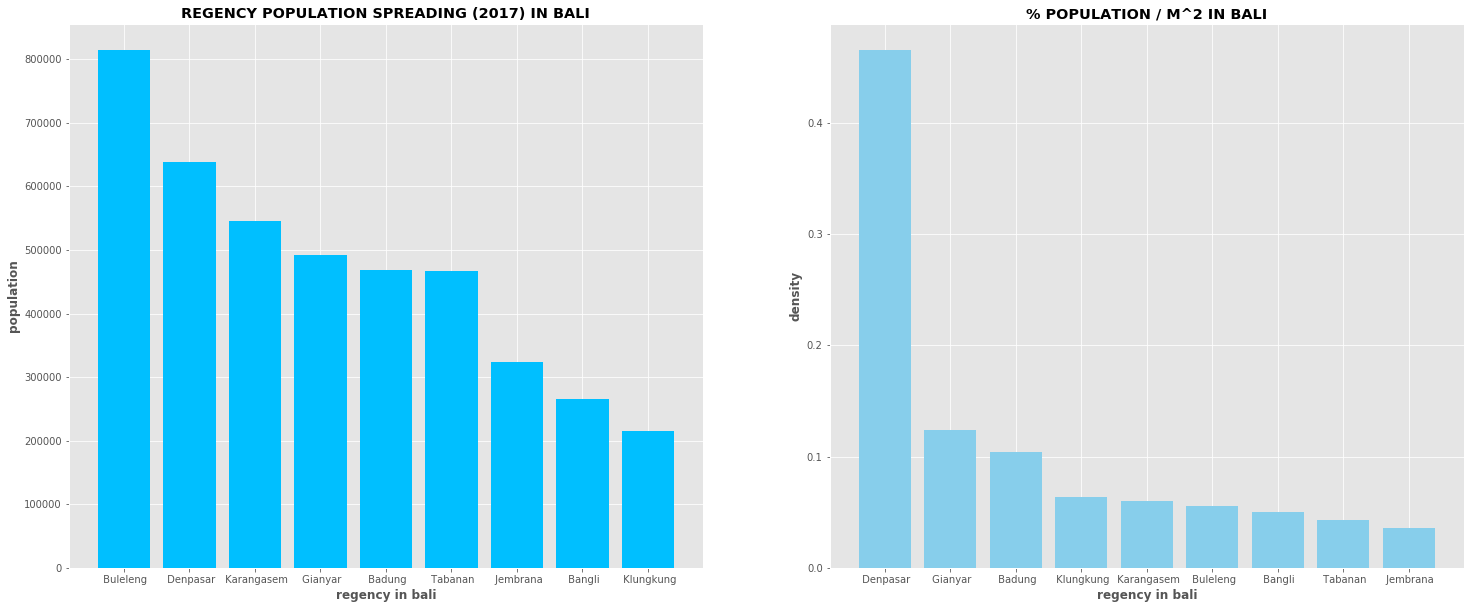

In [64]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=[25,10], ncols=2)

#visualize population
temp    = bali.sort_values('population (2017)', ascending=False)
ax[0].bar(temp['regency'], temp['population (2017)'], color='deepskyblue')
ax[0].set_xlabel('regency in bali', fontweight='bold')
ax[0].set_ylabel('population', fontweight='bold')
ax[0].set_title('REGENCY POPULATION SPREADING (2017) IN BALI', fontweight='bold')


#visualize density in regency
ax[1].bar(bali['regency'], (bali['density (population / m2)'] / sum(bali['density (population / m2)'])), color='skyblue')
ax[1].set_xlabel('regency in bali', fontweight='bold')
ax[1].set_ylabel('density', fontweight='bold')
ax[1].set_title('% POPULATION / M^2 IN BALI', fontweight='bold')


plt.show()

In [269]:
bali

,regency,central goverment,mayor,area (KM2),population (2017),sub district,village,density (population / m2)
8,Denpasar,Denpasar,Ida Bagus Rai Dharmawijaya Mantra,127,638548,4,16/27,5.027937
3,Gianyar,Gianyar,I Made Agus Mahayastra,368,492757,7,6/64,1.339014
0,Badung,Mangupura,I Nyoman Giri Prasta,418,468346,6,16/46,1.120445
6,Klungkung,Semarapura,I Nyoman Suwirta,315,215852,4,6/53,0.685244
5,Karangasem,Amlapura,I Gusti Ayu Mas Sumatri,839,545389,8,3/75,0.650046
2,Buleleng,Singaraja,Putu Agus Suradnyana,1364,814356,9,19/129,0.597035
1,Bangli,Bangli,I Made Gianyar,490,264945,4,4/68,0.540704
7,Tabanan,Tabanan,Ni Putu Eka Wiryastuti,1013,466647,10,-/133,0.460658
4,Jembrana,Negara,I Putu Artha,841,323211,5,10/41,0.384317


# 1.2 EDA ON WORKER DATA

In [65]:
#load worker dataset
worker  = pd.read_excel('data/pekerja.xlsx', skiprows=5)
worker

,Unnamed: 0,Establishment,Worker,Establishment.1,Worker.1,Establishment.2,Worker.2
0,Jembrana,5.0,1901.0,18.0,704.0,23.0,2605.0
1,Tabanan,6.0,833.0,21.0,1076.0,27.0,1909.0
2,Badung,17.0,4467.0,44.0,1840.0,61.0,6307.0
3,Gianyar,9.0,1693.0,40.0,1627.0,49.0,3320.0
4,Klungkung,0.0,0.0,18.0,785.0,18.0,785.0
5,Bangli,2.0,276.0,5.0,145.0,7.0,421.0
6,Karangasem,0.0,0.0,7.0,364.0,7.0,364.0
7,Buleleng,2.0,313.0,13.0,495.0,15.0,808.0
8,Denpasar,21.0,7916.0,120.0,5039.0,141.0,12955.0
9,Jumlah / Total :,62.0,17399.0,286.0,12075.0,348.0,29474.0


In [66]:
#rename column
worker.rename(columns= {'Unnamed: 0': 'regency', 
                        'Establishment': 'large industry', 'Worker':'li_Worker', 'Establishment.1': 'medium industry', 'Worker.1':'me_industry',
       'Establishment.2': 'total industry', 'Worker.2': 'total worker'}, inplace=True)

worker  = worker[0:9]

In [67]:
#change data type into integer
for i in worker.select_dtypes(include=['float64']):
    worker[i] = worker[i].astype('int64')

In [68]:
#sort dataframe from total worker value
worker.sort_values('total worker', ascending=False, inplace=True)

In [272]:
worker

,regency,large industry,li_Worker,medium industry,me_industry,total industry,total worker
8,Denpasar,21,7916,120,5039,141,12955
2,Badung,17,4467,44,1840,61,6307
3,Gianyar,9,1693,40,1627,49,3320
0,Jembrana,5,1901,18,704,23,2605
1,Tabanan,6,833,21,1076,27,1909
7,Buleleng,2,313,13,495,15,808
4,Klungkung,0,0,18,785,18,785
5,Bangli,2,276,5,145,7,421
6,Karangasem,0,0,7,364,7,364


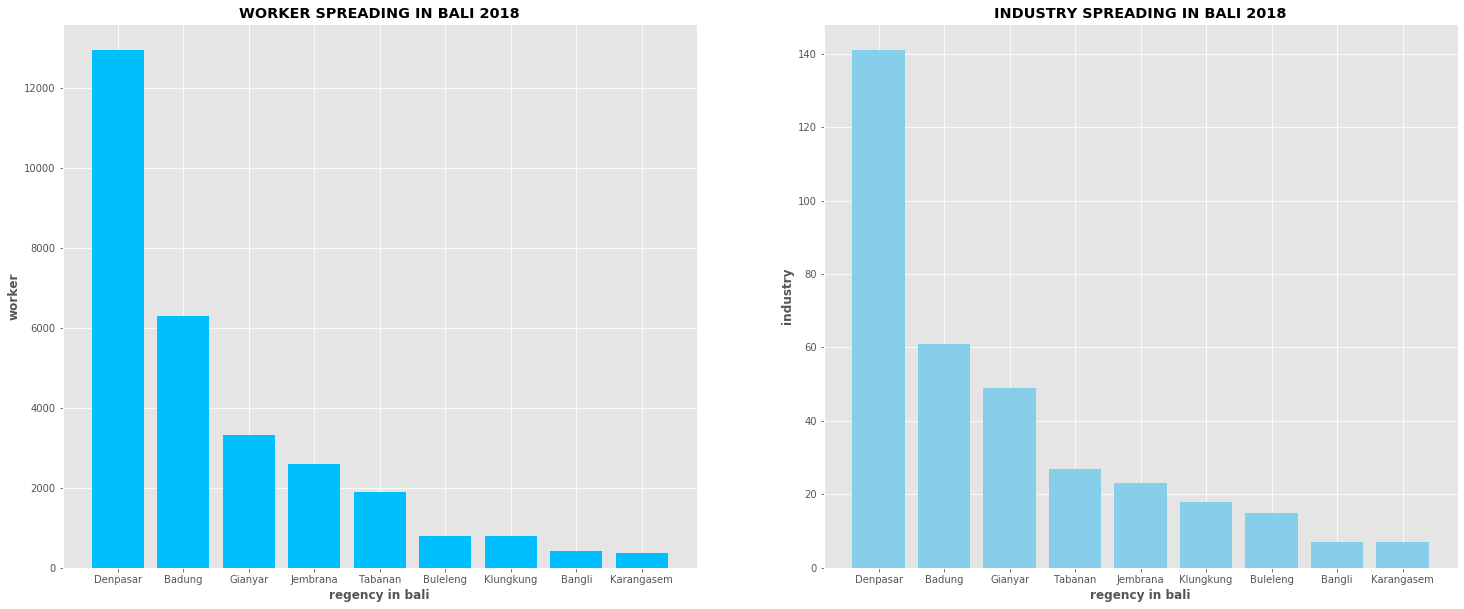

In [69]:
fig, ax = plt.subplots(figsize=[25,10], ncols=2)

#visualize total worker
ax[0].bar(worker['regency'], worker['total worker'], color='deepskyblue')
ax[0].set_xlabel('regency in bali', fontweight='bold')
ax[0].set_ylabel('worker', fontweight='bold')
ax[0].set_title('WORKER SPREADING IN BALI 2018', fontweight='bold')

#visualize total industri
temp = worker.sort_values('total industry', ascending=False)
ax[1].bar(temp['regency'], temp['total industry'], color='skyblue')
ax[1].set_xlabel('regency in bali', fontweight='bold')
ax[1].set_ylabel('industry', fontweight='bold')
ax[1].set_title('INDUSTRY SPREADING IN BALI 2018', fontweight='bold')

plt.show()

NOW WE KNOW THAT DENPASAR IS THE MOST STRATEGIC REGENCY TO OPEN RESTAURANT, THE CONSIDERATION WE TAKE ARE DENSITY OF POPULATION AND INDUSTRY SPREADING IN REGENCY IS LEANING TO DENPASAR

In [70]:
#visualize denpasar map
geolocator   = Nominatim(user_agent='coursera_assignment')
location    = geolocator.geocode('Denpasar, Bali')

denpasar    = folium.Map([location.latitude, location.longitude], zoom_start=13, min_zoom=13, max_zoom=13)

folium.CircleMarker(
    [location.latitude, location.longitude],
    radius=350,
    fill=True,
    fill_color='#00bfff',
    fill_opacity=0.2,
    parse_html=False
    ).add_to(denpasar)
denpasar    

## LETS FIND OUT ANY RECOMMENDATION RESTAURANT IN DENPASAR

In [71]:
#create function for filter categories
def get_category(row):
    try:
        category_list   = row['categories']
    
    except:
        category_list   = row['venue.categories']
    
    if len(category_list) == 0:
        return None
    
    else:
        return category_list[0]['name']

#create function for get restaurant label
def get_label(row):
    if (row.find('Restaurant') != -1) or (row.find('Café') != -1) or \
    (row.find('Fried') != -1) or (row.find('Coffee') != -1) or (row.find('Bar') != -1)\
    or (row.find('Bakery') != -1) or (row.find('Chips') != -1) or (row.find('Joint') != -1) \
    or (row.find('Food') != -1) or (row.find('Breakfast') != -1) or (row.find('Noodle') != -1)\
    or (row.find('Pizza') != -1):
        return 1

    else:
        return 0

In [72]:
#input credential information about our api data

CLIENT_ID   = 'QMAJS1DGBLWIPIQAUKXZ1HSYANFW2HLRFQKBCF1HTN52V0L5'
CLIENT_SECRET   = 'RH5IXXL2L4CWSTAJMTTCFSPRA0DAA3IWM3DWUCEP243T2BXT'
VERSION = '20180323'
RADIUS  = 5000
LIMIT   = 250
PRICE   = '1'

url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={location.latitude},{location.longitude}&radius={RADIUS}&limit={LIMIT}&price={PRICE}'

In [73]:
#set request into foursquare qpi (for get restaurant with price rating 1 / low)
result  = requests.get(url).json()

In [74]:
#filter our data using function above
venues = result['response']['groups'][0]['items']
p1 = pd.io.json.json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
p1 = p1.loc[:, filtered_columns]

p1['venue.categories'] = p1.apply(get_category, axis=1)
p1.columns = [col.split(".")[-1] for col in p1.columns]

p1['price'] = 'low price'
p1['restaurant']    = p1['categories'].apply(get_label)
p1

,name,categories,lat,lng,price,restaurant
0,Bakso Soto IMBO,Breakfast Spot,-8.659310,115.209071,low price,1
1,Holland Martabak & Terang Bulan,Bakery,-8.666711,115.222981,low price,1
2,"Sumber Bestik 5 ""Pak Darmo""",Food Truck,-8.642787,115.202877,low price,1
3,Bali Bakery (Patisserie & Cafe),Bakery,-8.661364,115.239778,low price,1
4,Holland Bakery,Bakery,-8.673015,115.229017,low price,1
5,Sop Kaki Kambing Suka Mampir,Diner,-8.638644,115.201354,low price,0
6,Soto Singapore,Breakfast Spot,-8.630553,115.223835,low price,1
7,Conato Bakery,Bakery,-8.648955,115.229905,low price,1
8,BreadTalk,Bakery,-8.636685,115.214662,low price,1
9,"Siomay Pak Lebah, jln Dr. Muwardi Renon-Denpasar",Diner,-8.670610,115.237146,low price,0


In [75]:
#change price range into 2
PRICE   = '2'

url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={location.latitude},{location.longitude}&radius={RADIUS}&limit={LIMIT}&price={PRICE}'

In [76]:
#sent request into foursquare API (for get restaurant with price rating 2 / middle low price)
result  = requests.get(url).json()

In [77]:
#filter our data using function above
venues = result['response']['groups'][0]['items']
p2 = pd.io.json.json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
p2 = p2.loc[:, filtered_columns]

p2['venue.categories'] = p2.apply(get_category, axis=1)
p2.columns = [col.split(".")[-1] for col in p2.columns]

p2['price'] = 'middle low price'
p2['restaurant']    = p2['categories'].apply(get_label)
p2

,name,categories,lat,lng,price,restaurant
0,Kopi Bali Cap Kupu-Kupu Bola Dunia,Coffee Shop,-8.655491,115.213394,middle low price,1
1,Warung Rujak Bisma,Salad Place,-8.650706,115.214355,middle low price,0
2,Mitos Kopi,Coffee Shop,-8.653779,115.215148,middle low price,1
3,Warung Pojok,Indonesian Restaurant,-8.640958,115.221910,middle low price,1
4,Warung Wardani,Indonesian Restaurant,-8.651159,115.215957,middle low price,1
...,...,...,...,...,...,...
95,Warung GURIH GURIH,Indonesian Restaurant,-8.684304,115.234955,middle low price,1
96,Funny Pancake 'n Coffee,Dessert Shop,-8.697344,115.218927,middle low price,0
97,McDonald's,Fast Food Restaurant,-8.637011,115.185502,middle low price,1
98,Mie Aceh - Pondok Bangladesh,Asian Restaurant,-8.692040,115.218173,middle low price,1


In [78]:
#change price range into 3
PRICE   = '3'

url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={location.latitude},{location.longitude}&radius={RADIUS}&limit={LIMIT}&price={PRICE}'

In [79]:
#sent request into foursquare API (for get restaurant with price rating 3 / middle high price)
result  = requests.get(url).json()

In [80]:
#filter our data using function above
venues = result['response']['groups'][0]['items']
p3 = pd.io.json.json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
p3 = p3.loc[:, filtered_columns]

p3['venue.categories'] = p3.apply(get_category, axis=1)
p3.columns = [col.split(".")[-1] for col in p3.columns]

p3['price'] = 'middle high price'
p3['restaurant']    = p3['categories'].apply(get_label)
p3

,name,categories,lat,lng,price,restaurant
0,Sushi Tsuki,Japanese Restaurant,-8.635960,115.219081,middle high price,1
1,Gosha Kitchen & Patisserie,Steakhouse,-8.677157,115.228086,middle high price,0
2,Warung Tahu Tek Khas Jakarta,American Restaurant,-8.628744,115.208742,middle high price,1


In [81]:
#change price range into 4
PRICE   = '4'

url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={location.latitude},{location.longitude}&radius={RADIUS}&limit={LIMIT}&price={PRICE}'

In [82]:
#sent request into foursquare API (for get restaurant with price rating 4 / high price)
result  = requests.get(url).json()

In [83]:
#filter our data using function above
try:
    venues = result['response']['groups'][0]['items']
    p4 = pd.io.json.json_normalize(venues)
    
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    p4 = p4.loc[:, filtered_columns]
    
    p4['venue.categories'] = p4.apply(get_category, axis=1)
    p4.columns = [col.split(".")[-1] for col in p4.columns]
    
    p4['price'] = 'middle high price'
    p4['restaurant']    = p4['categories'].apply(get_label)
    p4
except:
    print('denpasar dont have 4 rating restaurant')
    pass

denpasar dont have 4 rating restaurant


# Its look like we not find the high price restaurant in denpasar, so we can just keep going 

In [154]:
#concate moddle up and middle down data
price   = pd.concat([p1,p2,p3])
price.reset_index(inplace=True, drop=True)

In [155]:
price

,name,categories,lat,lng,price,restaurant
0,Bakso Soto IMBO,Breakfast Spot,-8.659310,115.209071,low price,1
1,Holland Martabak & Terang Bulan,Bakery,-8.666711,115.222981,low price,1
2,"Sumber Bestik 5 ""Pak Darmo""",Food Truck,-8.642787,115.202877,low price,1
3,Bali Bakery (Patisserie & Cafe),Bakery,-8.661364,115.239778,low price,1
4,Holland Bakery,Bakery,-8.673015,115.229017,low price,1
...,...,...,...,...,...,...
120,Mie Aceh - Pondok Bangladesh,Asian Restaurant,-8.692040,115.218173,middle low price,1
121,Mie Ayam Bandung,Noodle House,-8.693710,115.218566,middle low price,1
122,Sushi Tsuki,Japanese Restaurant,-8.635960,115.219081,middle high price,1
123,Gosha Kitchen & Patisserie,Steakhouse,-8.677157,115.228086,middle high price,0


In [169]:
price[price['restaurant'] == 0].sort_index()

,name,categories,lat,lng,price,restaurant
5,Sop Kaki Kambing Suka Mampir,Diner,-8.638644,115.201354,low price,0
9,"Siomay Pak Lebah, jln Dr. Muwardi Renon-Denpasar",Diner,-8.670610,115.237146,low price,0
10,Spatula Kitchen,Diner,-8.664821,115.239331,low price,0
23,Warung Rujak Bisma,Salad Place,-8.650706,115.214355,middle low price,0
34,Warung Be Sanur,Soup Place,-8.668921,115.228053,middle low price,0
35,J.Co Donuts & Coffee,Donut Shop,-8.636625,115.214651,middle low price,0
47,Dunkin',Donut Shop,-8.635721,115.217111,middle low price,0
54,Kantin Parahyangan (Caroline),Snack Place,-8.670667,115.215985,middle low price,0
71,SAI LAQU,Snack Place,-8.666957,115.241918,middle low price,0
74,J.co,Dessert Shop,-8.678685,115.205030,middle low price,0


In [172]:
for i in price.index[[5, 9, 10, 23, 34, 54, 71, 76, 123]]:
    price['restaurant'][i] = 1

In [182]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        125 non-null    object 
 1   categories  125 non-null    object 
 2   lat         125 non-null    float64
 3   lng         125 non-null    float64
 4   price       125 non-null    object 
 5   restaurant  125 non-null    int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 6.0+ KB


In [274]:
price.head()

,name,categories,lat,lng,price,restaurant,label,colorlabel
0,Bakso Soto IMBO,Breakfast Spot,-8.659310,115.209071,low price,1,18,lightgray
1,Holland Martabak & Terang Bulan,Bakery,-8.666711,115.222981,low price,1,1,red
2,"Sumber Bestik 5 ""Pak Darmo""",Food Truck,-8.642787,115.202877,low price,1,16,lightblue
3,Bali Bakery (Patisserie & Cafe),Bakery,-8.661364,115.239778,low price,1,1,red
4,Holland Bakery,Bakery,-8.673015,115.229017,low price,1,1,red


# there are some misslabel in our data, we must fix it (restaurant but not get into restaurant label)

In [188]:
#visualize  map with restaurant map
denpasar    = folium.Map([location.latitude, location.longitude], zoom_start=13, min_zoom=13, max_zoom=13)

folium.CircleMarker(
    [location.latitude, location.longitude],
    radius=350,
    fill=True,
    fill_color='#00bfff',
    fill_opacity=0.2,
    parse_html=False
    ).add_to(denpasar)

dmap = price[price['restaurant'] == 1]
for lat, lng, name, c in zip(dmap['lat'], dmap['lng'], dmap['name'],dmap['price']):
    if c == 'low price':
        color = 'green'
    elif c == 'middle low price':
        color = 'blue'
    elif c == 'middle high price':
        color = 'red'
    

    label = folium.Popup(name, parse_html=True)
    
    folium.Marker(
        [lat, lng],
        radius=5,
        popup=label,
        icon=folium.Icon(color=color, icon='circle', prefix='fa'),
        fill=True,
        fill_color='#00bfff',
        fill_opacity=0.2        
        ).add_to(denpasar)

legend = """
        <div style="position: fixed;
                    bottom:50px; left: 50px;
                    z-index:9999;                    
                    padding: 10px;
                    ">
        <b style="color: green;">low price</b><hr>
        <b style="color: blue;"> middle low price</b><hr>
        <b style="color: red;"> middle high price</b>
        </div>
        """
denpasar.get_root().html.add_child(folium.Element(legend))
denpasar

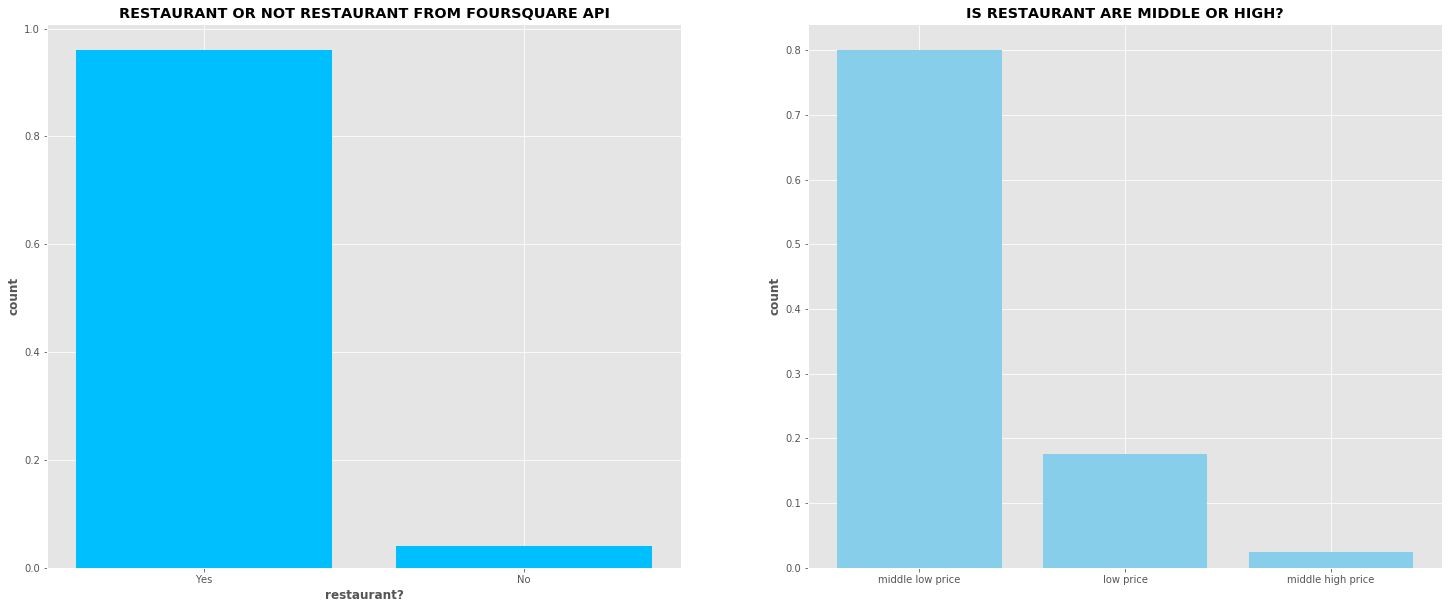

In [189]:
fig, ax = plt.subplots(figsize=[25,10], ncols=2)

#visualize restaurant or not
ax[0].bar(['Yes','No'], (price['restaurant'].value_counts() / len(price['restaurant'])), color='deepskyblue')
ax[0].set_title('RESTAURANT OR NOT RESTAURANT FROM FOURSQUARE API', fontweight='bold')
ax[0].set_ylabel('count', fontweight='bold')
ax[0].set_xlabel('restaurant?', fontweight='bold')

#visualize is restaurant are middle or high
ax[1].bar(price['price'].value_counts().index, (price['price'].value_counts() / len(price['price'])), color='skyblue')
ax[1].set_title('IS RESTAURANT ARE MIDDLE OR HIGH?', fontweight='bold')
ax[1].set_ylabel('count', fontweight='bold')
plt.show()

# WE ALREADY GOT A GOOD INSIGHT ABOUT OUR DATA, BUT I THINK THAT WE MUST KEEP GOING TO LEARN MORE ABOUT THIS DATA, LETS CLUSTER OUR DATA TO SEE IS THERE A HIDDEN PATTERN BEHIND OUR DATA

In [198]:
price.head()

,name,categories,lat,lng,price,restaurant
0,Bakso Soto IMBO,Breakfast Spot,-8.659310,115.209071,low price,1
1,Holland Martabak & Terang Bulan,Bakery,-8.666711,115.222981,low price,1
2,"Sumber Bestik 5 ""Pak Darmo""",Food Truck,-8.642787,115.202877,low price,1
3,Bali Bakery (Patisserie & Cafe),Bakery,-8.661364,115.239778,low price,1
4,Holland Bakery,Bakery,-8.673015,115.229017,low price,1


In [199]:
#create new dataframe for traing our knn
X = price[['categories', 'lat', 'lng', 'price', 'restaurant']]

In [200]:
#labelencode & onehotencode category column
X['price'] = X['price'].replace({'low price':1, 'middle low price':2, 'middle high price':3})
X = pd.get_dummies(X)

In [202]:
X.head()

,lat,lng,price,restaurant,categories_American Restaurant,categories_Asian Restaurant,categories_BBQ Joint,categories_Bakery,categories_Breakfast Spot,categories_Café,categories_Chinese Restaurant,categories_Coffee Shop,categories_Dessert Shop,categories_Dim Sum Restaurant,categories_Diner,categories_Donut Shop,categories_Fast Food Restaurant,categories_Food Truck,categories_Fried Chicken Joint,categories_Indian Restaurant,categories_Indonesian Restaurant,categories_Italian Restaurant,categories_Japanese Restaurant,categories_Juice Bar,categories_Lounge,categories_Noodle House,categories_Pizza Place,categories_Restaurant,categories_Salad Place,categories_Seafood Restaurant,categories_Snack Place,categories_Soup Place,categories_Steakhouse,categories_Vegetarian / Vegan Restaurant
0,-8.659310,115.209071,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-8.666711,115.222981,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-8.642787,115.202877,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-8.661364,115.239778,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-8.673015,115.229017,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [203]:
#train our model and search the best K cluster of our data
from sklearn.cluster import KMeans

sse     = []
label   = []

for i in np.arange(2,50):
    kmeans = KMeans(n_clusters=i).fit(X)
    sse.append(kmeans.inertia_)

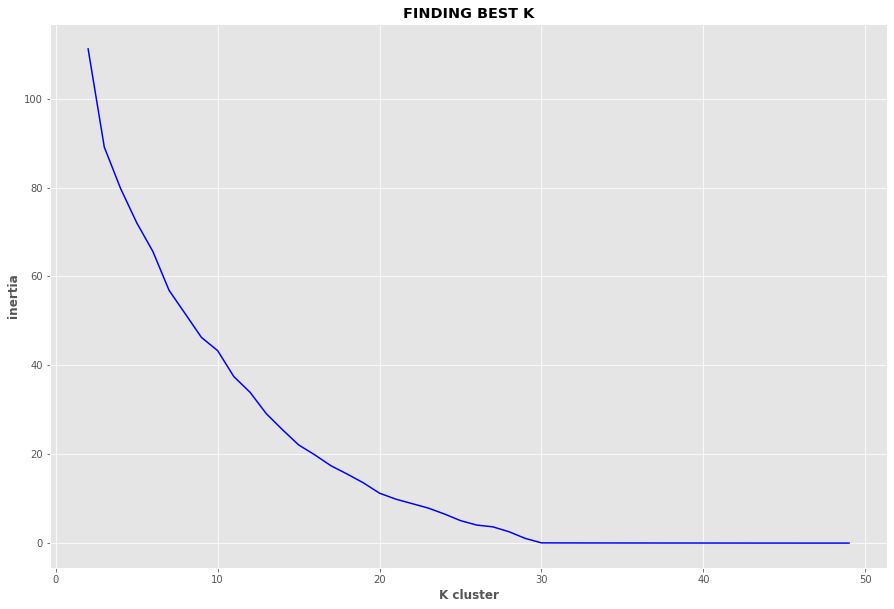

In [209]:
#visualize our dataset
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(np.arange(2,50), sse, color='blue')
ax.set_xlabel('K cluster', fontweight='bold')
ax.set_ylabel('inertia', fontweight='bold')
ax.set_title('FINDING BEST K', fontweight='bold')
plt.show()

In [253]:
#the best K is 30, set our model then find the label
kmeans = KMeans(n_clusters=30).fit(X)
price['label'] = kmeans.labels_

In [249]:
price['label'].value_counts()[-(30-19):].index

Int64Index([12, 18, 21, 7, 22, 23, 24, 25, 26, 27, 29], dtype='int64')

In [261]:
#create new feature called colorlabel, this feature is used to visualize our cluster in folium

price['colorlabel'] = price['label']
price['colorlabel'].replace([1, 0, 3, 2, 8, 4, 5, 6, 9, 10, 15, 11, 13, 14, 16, 17, 19, 20, 28],['red', 'blue', 'green', 'purple', 'orange', 'darkred',
'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'], inplace=True)
price['colorlabel'].replace([12, 18, 21, 7, 22, 23, 24, 25, 26, 27, 29],'lightgray', inplace=True)


In [266]:
#inspect every cluster
for i in range(31):
    display(price[price['label'] == i])

,name,categories,lat,lng,price,restaurant,label,colorlabel
25,Warung Pojok,Indonesian Restaurant,-8.640958,115.221910,middle low price,1,0,blue
26,Warung Wardani,Indonesian Restaurant,-8.651159,115.215957,middle low price,1,0,blue
28,Dapoer Pemuda,Indonesian Restaurant,-8.653717,115.217061,middle low price,1,0,blue
29,Warung Bu Kris,Indonesian Restaurant,-8.640976,115.208750,middle low price,1,0,blue
33,Warung Kedaton,Indonesian Restaurant,-8.657206,115.232002,middle low price,1,0,blue
37,Warung Sari Manis,Indonesian Restaurant,-8.667076,115.234696,middle low price,1,0,blue
52,Kedai Sudi Mampir Sop Kaki Kambing,Indonesian Restaurant,-8.641513,115.209196,middle low price,1,0,blue
57,Warung Sate Plecing Mak Lukluk,Indonesian Restaurant,-8.673840,115.243818,middle low price,1,0,blue
59,Rujak Uma Bali,Indonesian Restaurant,-8.628078,115.224488,middle low price,1,0,blue
62,Warung Modus Bali,Indonesian Restaurant,-8.666107,115.238429,middle low price,1,0,blue


,name,categories,lat,lng,price,restaurant,label,colorlabel
1,Holland Martabak & Terang Bulan,Bakery,-8.666711,115.222981,low price,1,1,red
3,Bali Bakery (Patisserie & Cafe),Bakery,-8.661364,115.239778,low price,1,1,red
4,Holland Bakery,Bakery,-8.673015,115.229017,low price,1,1,red
7,Conato Bakery,Bakery,-8.648955,115.229905,low price,1,1,red
8,BreadTalk,Bakery,-8.636685,115.214662,low price,1,1,red
12,Holland Bakery,Bakery,-8.685791,115.216151,low price,1,1,red
13,GODDES BAKERY,Bakery,-8.681645,115.253293,low price,1,1,red
14,Pie Susu Asli Enaaak Renon,Bakery,-8.692754,115.238060,low price,1,1,red
15,Chef Cakes Bakery,Bakery,-8.672917,115.180818,low price,1,1,red
16,Conato Bakery Pakerisan,Bakery,-8.691000,115.226245,low price,1,1,red


,name,categories,lat,lng,price,restaurant,label,colorlabel
48,The Alleyway Cafe,Café,-8.666321,115.238596,middle low price,1,2,purple
79,Pod Chocolate Shop & Cafe Sanur,Café,-8.669316,115.256992,middle low price,1,2,purple
96,BARISTA Kitchen & Coffee Bar,Café,-8.672715,115.258468,middle low price,1,2,purple
113,St. Jhon Cafe,Café,-8.686875,115.206270,middle low price,1,2,purple


,name,categories,lat,lng,price,restaurant,label,colorlabel
36,Rumah Makan Kedaton,Asian Restaurant,-8.635777,115.218706,middle low price,1,3,green
44,Bakmi nyemek & serabi solo,Asian Restaurant,-8.642150,115.209083,middle low price,1,3,green
61,Ayam Tulang Lunak Hayam Wuruk,Asian Restaurant,-8.658365,115.239072,middle low price,1,3,green
77,Dimsum Manan,Asian Restaurant,-8.646345,115.195552,middle low price,1,3,green
80,Restoran Renon,Asian Restaurant,-8.666900,115.235802,middle low price,1,3,green
100,Bakso Sapi Asli Riandy.M,Asian Restaurant,-8.673228,115.181895,middle low price,1,3,green
120,Mie Aceh - Pondok Bangladesh,Asian Restaurant,-8.692040,115.218173,middle low price,1,3,green


,name,categories,lat,lng,price,restaurant,label,colorlabel
22,Kopi Bali Cap Kupu-Kupu Bola Dunia,Coffee Shop,-8.655491,115.213394,middle low price,1,4,darkred
24,Mitos Kopi,Coffee Shop,-8.653779,115.215148,middle low price,1,4,darkred
30,Playboy's Coffee House,Coffee Shop,-8.649234,115.221453,middle low price,1,4,darkred
31,Home Bistro,Coffee Shop,-8.649408,115.220853,middle low price,1,4,darkred
42,Foam Coffee and Coin Laundry,Coffee Shop,-8.665820,115.237884,middle low price,1,4,darkred
43,Starbucks,Coffee Shop,-8.669557,115.215233,middle low price,1,4,darkred
56,Helo Cafe,Coffee Shop,-8.675016,115.217580,middle low price,1,4,darkred
58,Revayah Coffee,Coffee Shop,-8.636074,115.241534,middle low price,1,4,darkred
66,Tukang Kopi,Coffee Shop,-8.684519,115.214531,middle low price,1,4,darkred
78,Starbucks,Coffee Shop,-8.673324,115.244440,middle low price,1,4,darkred


,name,categories,lat,lng,price,restaurant,label,colorlabel
27,Mie ayam jakarta,Chinese Restaurant,-8.649087,115.228797,middle low price,1,5,lightred
38,Depot Indra,Chinese Restaurant,-8.643579,115.220364,middle low price,1,5,lightred
45,Depot Wira,Chinese Restaurant,-8.635896,115.206999,middle low price,1,5,lightred
68,Warung Sushi Kawe,Chinese Restaurant,-8.678320,115.206861,middle low price,1,5,lightred
86,Kedai 99 Chinese Cuisine,Chinese Restaurant,-8.676950,115.234717,middle low price,1,5,lightred
108,Depot Gang Djangkrik,Chinese Restaurant,-8.681492,115.193222,middle low price,1,5,lightred
109,Hengky Resto,Chinese Restaurant,-8.637199,115.249704,middle low price,1,5,lightred
114,Nasi Campur Pontianak Asiang,Chinese Restaurant,-8.696803,115.218976,middle low price,1,5,lightred


,name,categories,lat,lng,price,restaurant,label,colorlabel
35,J.Co Donuts & Coffee,Donut Shop,-8.636625,115.214651,middle low price,0,6,beige
47,Dunkin',Donut Shop,-8.635721,115.217111,middle low price,0,6,beige


,name,categories,lat,lng,price,restaurant,label,colorlabel
49,Marugame Udon,Noodle House,-8.676021,115.207144,middle low price,1,7,lightgray
73,Depot LUCAS,Noodle House,-8.645241,115.185576,middle low price,1,7,lightgray
84,Depot Pelangi Mie Ayam Jakarta,Noodle House,-8.635521,115.225055,middle low price,1,7,lightgray
91,Bakso Solo Wonogiri,Noodle House,-8.685375,115.206450,middle low price,1,7,lightgray
116,Mie Badrun,Noodle House,-8.645778,115.237253,middle low price,1,7,lightgray
121,Mie Ayam Bandung,Noodle House,-8.693710,115.218566,middle low price,1,7,lightgray


,name,categories,lat,lng,price,restaurant,label,colorlabel
82,TWISSTERDOG Home Potato,Fast Food Restaurant,-8.681541,115.225101,middle low price,1,8,orange
105,McDonald's,Fast Food Restaurant,-8.681947,115.191721,middle low price,1,8,orange
110,Richeese Factory,Fast Food Restaurant,-8.636862,115.184736,middle low price,1,8,orange
119,McDonald's,Fast Food Restaurant,-8.637011,115.185502,middle low price,1,8,orange


,name,categories,lat,lng,price,restaurant,label,colorlabel
32,Domino's Pizza,Pizza Place,-8.635799,115.219743,middle low price,1,9,darkblue
39,Pizza Hut,Pizza Place,-8.667478,115.215372,middle low price,1,9,darkblue
40,Pizza Hut,Pizza Place,-8.635896,115.218102,middle low price,1,9,darkblue
97,Panties Pizza,Pizza Place,-8.636922,115.184415,middle low price,1,9,darkblue


,name,categories,lat,lng,price,restaurant,label,colorlabel
51,Ikan Bakar Cianjur (IBC),Seafood Restaurant,-8.667032,115.236118,middle low price,1,10,darkgreen
60,Warung Ongan & Tahari Sushi 2,Seafood Restaurant,-8.634183,115.234290,middle low price,1,10,darkgreen
104,Warung Subak,Seafood Restaurant,-8.611734,115.218947,middle low price,1,10,darkgreen


,name,categories,lat,lng,price,restaurant,label,colorlabel
46,Warung Siobak Singaraja,BBQ Joint,-8.652620,115.210849,middle low price,1,11,darkpurple
50,Babi Guling Sariastri,BBQ Joint,-8.649102,115.227650,middle low price,1,11,darkpurple
55,Warung Babi Guling KUSUMA DEWI,BBQ Joint,-8.635040,115.223027,middle low price,1,11,darkpurple
83,Babi Guling Singaraja RENDI,BBQ Joint,-8.693045,115.226429,middle low price,1,11,darkpurple
95,Warung Babi Guling Penatih I Nyoman Siring,BBQ Joint,-8.616567,115.240515,middle low price,1,11,darkpurple


,name,categories,lat,lng,price,restaurant,label,colorlabel
74,J.co,Dessert Shop,-8.678685,115.205030,middle low price,0,12,lightgray
118,Funny Pancake 'n Coffee,Dessert Shop,-8.697344,115.218927,middle low price,0,12,lightgray


,name,categories,lat,lng,price,restaurant,label,colorlabel
5,Sop Kaki Kambing Suka Mampir,Diner,-8.638644,115.201354,low price,1,13,white
9,"Siomay Pak Lebah, jln Dr. Muwardi Renon-Denpasar",Diner,-8.670610,115.237146,low price,1,13,white
10,Spatula Kitchen,Diner,-8.664821,115.239331,low price,1,13,white


,name,categories,lat,lng,price,restaurant,label,colorlabel
54,Kantin Parahyangan (Caroline),Snack Place,-8.670667,115.215985,middle low price,1,14,pink
71,SAI LAQU,Snack Place,-8.666957,115.241918,middle low price,1,14,pink
76,Jagung Sion,Snack Place,-8.673216,115.230713,middle low price,1,14,pink


,name,categories,lat,lng,price,restaurant,label,colorlabel
93,KFC Tukad Pakerisan,Fried Chicken Joint,-8.684352,115.226038,middle low price,1,15,cadetblue
102,KFC / KFC Coffee,Fried Chicken Joint,-8.681884,115.191115,middle low price,1,15,cadetblue
115,KFC / KFC Coffee,Fried Chicken Joint,-8.636964,115.185122,middle low price,1,15,cadetblue


,name,categories,lat,lng,price,restaurant,label,colorlabel
2,"Sumber Bestik 5 ""Pak Darmo""",Food Truck,-8.642787,115.202877,low price,1,16,lightblue
11,Bakwan Malang,Food Truck,-8.651080,115.189098,low price,1,16,lightblue


,name,categories,lat,lng,price,restaurant,label,colorlabel
124,Warung Tahu Tek Khas Jakarta,American Restaurant,-8.628744,115.208742,middle high price,1,17,lightgreen


,name,categories,lat,lng,price,restaurant,label,colorlabel
0,Bakso Soto IMBO,Breakfast Spot,-8.659310,115.209071,low price,1,18,lightgray
6,Soto Singapore,Breakfast Spot,-8.630553,115.223835,low price,1,18,lightgray


,name,categories,lat,lng,price,restaurant,label,colorlabel
23,Warung Rujak Bisma,Salad Place,-8.650706,115.214355,middle low price,1,19,gray


,name,categories,lat,lng,price,restaurant,label,colorlabel
98,Roti Canai & Teh Tarik Bunana,Indian Restaurant,-8.635698,115.24266,middle low price,1,20,black


,name,categories,lat,lng,price,restaurant,label,colorlabel
123,Gosha Kitchen & Patisserie,Steakhouse,-8.677157,115.228086,middle high price,1,21,lightgray


,name,categories,lat,lng,price,restaurant,label,colorlabel
64,IL Pomodoro,Italian Restaurant,-8.636595,115.195475,middle low price,1,22,lightgray


,name,categories,lat,lng,price,restaurant,label,colorlabel
19,Moena Fresh,Juice Bar,-8.638014,115.254536,low price,1,23,lightgray


,name,categories,lat,lng,price,restaurant,label,colorlabel
94,ESTRELLA LOUNGE AND CINEMA,Lounge,-8.685429,115.23037,middle low price,0,24,lightgray


,name,categories,lat,lng,price,restaurant,label,colorlabel
122,Sushi Tsuki,Japanese Restaurant,-8.63596,115.219081,middle high price,1,25,lightgray


,name,categories,lat,lng,price,restaurant,label,colorlabel
75,Kou Dimsum Parlour,Dim Sum Restaurant,-8.673253,115.243987,middle low price,1,26,lightgray


,name,categories,lat,lng,price,restaurant,label,colorlabel
34,Warung Be Sanur,Soup Place,-8.668921,115.228053,middle low price,1,27,lightgray


,name,categories,lat,lng,price,restaurant,label,colorlabel
53,Depot Alami,Vegetarian / Vegan Restaurant,-8.631558,115.217098,middle low price,1,28,lightgray


,name,categories,lat,lng,price,restaurant,label,colorlabel
41,Goemerot Restaurant,Restaurant,-8.675372,115.227971,middle low price,1,29,lightgray


,name,categories,lat,lng,price,restaurant,label,colorlabel


In [262]:
#visualize  map with restaurant map
denpasar    = folium.Map([location.latitude, location.longitude], zoom_start=13, min_zoom=13, max_zoom=13)

folium.CircleMarker(
    [location.latitude, location.longitude],
    radius=350,
    fill=True,
    fill_color='#00bfff',
    fill_opacity=0.2,
    parse_html=False
    ).add_to(denpasar)

dmap = price[price['restaurant'] == 1]
for lat, lng, name, c in zip(dmap['lat'], dmap['lng'], dmap['name'], dmap['colorlabel']):    

    label = folium.Popup(name, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=c,
        popup=label,        
        fill=True,
        fill_color='#00bfff',
        fill_opacity=0.2        
        ).add_to(denpasar)
denpasar

# CONCLUSION
in the end, we get insight:
<ol>
<li>Denpasar is great place for opening restaurant because the population density and center of industry in bali</li>
<li>Restaurant in denpasar mostly are  middle low price about 80%, second are low price and the uncommon are middle high price</li>
<li>Seeing the existing trend, Denpasar people seem to prefer restaurants with medium prices and below</li>
</ol>